# Test Notebook

**Simple Execution** is the first test, where I manually instantiate all the necessary classes and perform a non-automatic computation.

**Multi-Round Execution** is the automatic computation of the algorithm.

In [1]:
import os
import numpy as np
import math

from Stationary.core import *
from Stationary.utils import *

from sklearn import linear_model, datasets
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt


## Simple Execution

In [2]:
w1 = Worker(coef = np.array([0, 0]), intercept = np.array([0]), model=linear_model.LinearRegression())
w2 = Worker(coef = np.array([0, 0]), intercept = np.array([0]), model=linear_model.LinearRegression())
w3 = Worker(coef = np.array([0, 0]), intercept = np.array([0]), model=linear_model.LinearRegression())

In [ ]:
l = []
l.append(w1)
l.append(w2)
l.append(w3)

In [ ]:
dataset_X, dataset_y = datasets.load_diabetes(return_X_y=True)

In [ ]:
server = Server(coef = np.array([0, 0]), intercept = np.array([0]), workers = l, num_features = dataset_X[0].size)

In [ ]:
train_w1_X, train_w2_X, train_w3_X, test_X = np.split(dataset_X, 
                                                      [int(.25 * len(dataset_X)), 
                                                       int(.50 * len(dataset_X)), 
                                                       int(.75 * len(dataset_X))
                                                      ])

In [ ]:
train_w1_y, train_w2_y, train_w3_y, test_y = np.split(dataset_y, 
                                                      [int(.25 * len(dataset_y)), 
                                                       int(.50 * len(dataset_y)), 
                                                       int(.75 * len(dataset_y))
                                                      ])

In [ ]:
train_w1_1, train_w1_2, train_w1_3 = np.split(train_w1_X,  
                                                [int(.33 * len(train_w1_X)), 
                                                int(.66 * len(train_w1_X))
                                                ])

train_w2_1, train_w2_2, train_w2_3 = np.split(train_w2_X,  
                                                [int(.33 * len(train_w2_X)), 
                                                int(.66 * len(train_w2_X))
                                                ])

train_w3_1, train_w3_2, train_w3_3 = np.split(train_w3_X,  
                                                [int(.33 * len(train_w3_X)), 
                                                int(.66 * len(train_w3_X))
                                                ])




train_w1_y_1, train_w1_y_2, train_w1_y_3 = np.split(train_w1_y, 
                                                      [int(.33 * len(train_w1_y)), 
                                                       int(.66 * len(train_w1_y))
                                                      ])

train_w2_y_1, train_w2_y_2, train_w2_y_3 = np.split(train_w2_y, 
                                                      [int(.33 * len(train_w2_y)), 
                                                       int(.66 * len(train_w2_y))
                                                      ])

train_w3_y_1, train_w3_y_2, train_w3_y_3 = np.split(train_w3_y, 
                                                      [int(.33 * len(train_w3_y)), 
                                                       int(.66 * len(train_w3_y))
                                                      ])

In [ ]:
w1.train(X = train_w1_X, y = train_w1_y)
w2.train(X = train_w2_X, y = train_w2_y)
w3.train(X = train_w3_X, y = train_w3_y)


In [ ]:
w3.model.coef_

In [ ]:
server.aggregation()

In [ ]:
print('Server Coef: ', server.coef)
print('Server intercept: ', server.intercept)

In [ ]:
server.return_to_workers()

In [ ]:
w3.coef

In [ ]:
pred_w1 = w1.evaluate(test_X)
print('Mean squared error worker 1: %.2f' 
         % mean_squared_error(test_y, pred_w1))
print('Coefficient of determinaton of worker 1: %.2f'
         % r2_score(test_y, pred_w1))

print('----------')

pred_w2 = w2.evaluate(test_X)
print('Mean squared error worker 2: %.2f' 
         % mean_squared_error(test_y, pred_w2))
print('Coefficient of determinaton of worker 2: %.2f'
         % r2_score(test_y, pred_w2))

print('----------')

pred_w3 = w3.evaluate(test_X)
print('Mean squared error worker 3: %.2f' 
         % mean_squared_error(test_y, pred_w3))
print('Coefficient of determinaton of worker 3: %.2f'
         % r2_score(test_y, pred_w3))

In [ ]:
server.return_to_workers()

In [ ]:
pred_server = server.evaluate(test_X)
print('Mean squared error: %.2f' 
         % mean_squared_error(test_y, pred_server))
print('Coefficient of determinaton: %.2f'
         % r2_score(test_y, pred_server))

# Multi Rounds

In [71]:
num_workers = 4
num_rounds = 100

m = 2.3
c = 1.6

In [72]:
dataset_X = np.linspace(0, 10, 2000)
np.random.shuffle(dataset_X)

dataset_y =  dataset_X * m + c +  np.random.randn(dataset_X.size) * math.sqrt(10)

dataset_X = dataset_X.reshape(-1,1)

In [73]:
worker_list = []
for i in range(0, num_workers):
    worker_list.append(Worker(coef = np.zeros(shape=dataset_X[0].size), intercept = np.zeros(shape=1), model=linear_model.LinearRegression()))

In [74]:
train_percentage = 0.9


train_X, test_X = np.split(dataset_X, 
            [int(train_percentage * len(dataset_X))
            ])

train_y, test_y = np.split(dataset_y, 
            [int(train_percentage * len(dataset_y))
            ])

In [75]:
server = Server(coef = np.zeros(shape=dataset_X[0].size), intercept = np.zeros(shape=1), workers = worker_list, num_features = dataset_X[0].size)

In [76]:
train_list_X = splitDataset(train_X, num_workers, num_rounds)
train_list_y = splitDataset(train_y, num_workers, num_rounds)

In [77]:
error = []
score = []

for i in range(0, num_rounds):
    
    for j in range(0, num_workers):
        worker_list[j].train(X = train_list_X[i*num_workers+j] , y = train_list_y[i*num_workers+j])

    server.aggregation() 
    server.return_to_workers()
    
    pred_server = server.evaluate(test_X)
    print('------ROUND {}------'.format(i+1))
    print('Mean squared error: %.3f' 
          % mean_squared_error(test_y, pred_server))
    print('Coefficient of determinaton: %.3f \n'
          % r2_score(test_y, pred_server))
    error.append(mean_squared_error(test_y, pred_server))
    score.append(r2_score(test_y, pred_server))
    

------ROUND 1------
Mean squared error: 9.971
Coefficient of determinaton: 0.801 

------ROUND 2------
Mean squared error: 9.856
Coefficient of determinaton: 0.804 

------ROUND 3------
Mean squared error: 9.794
Coefficient of determinaton: 0.805 

------ROUND 4------
Mean squared error: 9.938
Coefficient of determinaton: 0.802 

------ROUND 5------
Mean squared error: 10.078
Coefficient of determinaton: 0.799 

------ROUND 6------
Mean squared error: 9.931
Coefficient of determinaton: 0.802 

------ROUND 7------
Mean squared error: 9.877
Coefficient of determinaton: 0.803 

------ROUND 8------
Mean squared error: 9.844
Coefficient of determinaton: 0.804 

------ROUND 9------
Mean squared error: 9.860
Coefficient of determinaton: 0.804 

------ROUND 10------
Mean squared error: 9.856
Coefficient of determinaton: 0.804 

------ROUND 11------
Mean squared error: 9.829
Coefficient of determinaton: 0.804 

------ROUND 12------
Mean squared error: 9.856
Coefficient of determinaton: 0.804 



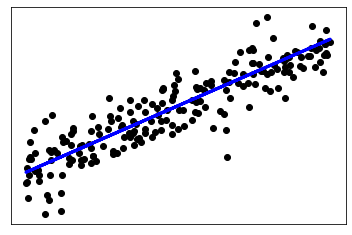

In [78]:
plt.scatter(test_X, test_y,  color='black')
plt.plot(test_X, pred_server, color='blue', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

<Figure size 720x360 with 0 Axes>

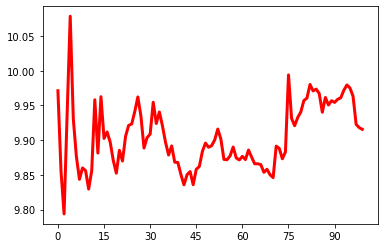

In [79]:
from matplotlib.pyplot import figure
from matplotlib.ticker import MaxNLocator

figure(figsize=(10,5))

x = np.arange(num_rounds)

ax = plt.figure().gca()

ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.plot(x, error, color='red', linewidth=3)

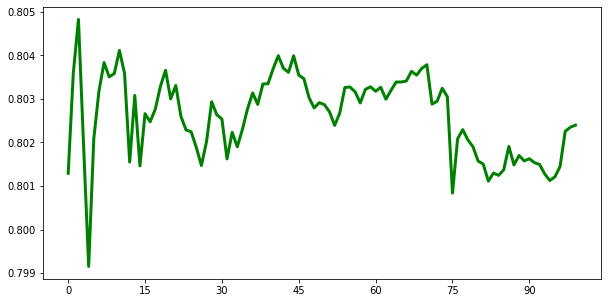

In [80]:
figure(figsize=(10,5))

x = np.arange(num_rounds)

plt.plot(x, score, color='green', linewidth=3)

ax = plt.gca()
ax.get_yaxis().get_major_formatter().set_scientific(False)

ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.draw()

## Evaluating only the single worker

In [82]:
worker_list = []
worker_list.append(Worker(coef = np.zeros(shape=dataset_X[0].size), intercept = np.zeros(shape=1), model=linear_model.LinearRegression()))

server = Server(coef = np.zeros(shape=dataset_X[0].size), intercept = np.zeros(shape=1), workers = worker_list, num_features = dataset_X[0].size)


error_single = []
score_single = []

for i in range(0, num_rounds):
    
    worker_list[0].train(X = train_list_X[i*num_workers] , y = train_list_y[i*num_workers])

    server.aggregation() 
    server.return_to_workers()
    
    pred_server = server.evaluate(test_X)
    print('------ROUND {}------'.format(i+1))
    print('Mean squared error: %.3f' 
          % mean_squared_error(test_y, pred_server))
    print('Coefficient of determinaton: %.3f \n'
          % r2_score(test_y, pred_server))
    error_single.append(mean_squared_error(test_y, pred_server))
    score_single.append(r2_score(test_y, pred_server))

------ROUND 1------
Mean squared error: 21.347
Coefficient of determinaton: 0.575 

------ROUND 2------
Mean squared error: 10.574
Coefficient of determinaton: 0.789 

------ROUND 3------
Mean squared error: 15.254
Coefficient of determinaton: 0.696 

------ROUND 4------
Mean squared error: 13.952
Coefficient of determinaton: 0.722 

------ROUND 5------
Mean squared error: 12.897
Coefficient of determinaton: 0.743 

------ROUND 6------
Mean squared error: 13.385
Coefficient of determinaton: 0.733 

------ROUND 7------
Mean squared error: 11.927
Coefficient of determinaton: 0.762 

------ROUND 8------
Mean squared error: 11.515
Coefficient of determinaton: 0.771 

------ROUND 9------
Mean squared error: 10.222
Coefficient of determinaton: 0.796 

------ROUND 10------
Mean squared error: 10.409
Coefficient of determinaton: 0.793 

------ROUND 11------
Mean squared error: 10.220
Coefficient of determinaton: 0.796 

------ROUND 12------
Mean squared error: 10.013
Coefficient of determinato

ValueError: x and y must have same first dimension, but have shapes (100,) and (0,)

<Figure size 720x360 with 0 Axes>

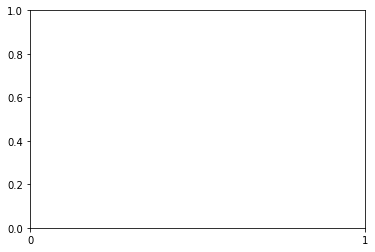

In [83]:
from matplotlib.pyplot import figure
from matplotlib.ticker import MaxNLocator

figure(figsize=(10,5))

x = np.arange(num_rounds)

ax = plt.figure().gca()

ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.plot(x, error, color='red', linewidth=3)
plt.plot(x, error_single, color='blue')

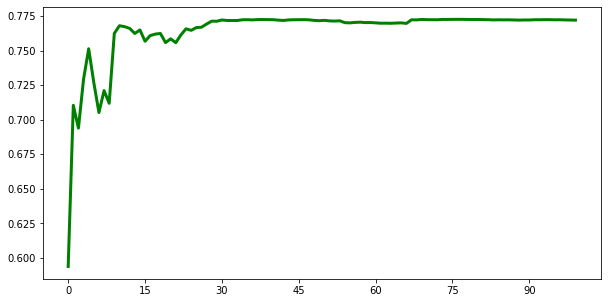

In [65]:
figure(figsize=(10,5))

x = np.arange(num_rounds)

plt.plot(x, score, color='green', linewidth=3)
plt.plot(x, score_single, color='blue')

ax = plt.gca()
ax.get_yaxis().get_major_formatter().set_scientific(False)

ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.draw()